In [283]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import akshare as ak  # 用于获取股票数据

In [284]:
# 获取A股002050的数据
def get_stock_data(stock_code, start, end):
    data = ak.stock_zh_a_hist(symbol=stock_code, period="daily", start_date=start, end_date=end, adjust="qfq")
    data.set_index("日期", inplace=True)  # 将日期列设置为索引
    print(len(data),data)
    return data[["收盘"]]  # 只获取收盘价

In [312]:
# 数据准备
stock_code = "002001"
price_data = get_stock_data(stock_code,"20100101","20250210")
scaler = MinMaxScaler(feature_range=(0, 1))  # 归一化数据到 [0, 1] 范围
scaled_data = scaler.fit_transform(price_data)  # 归一化数据

3641               股票代码     开盘     收盘     最高     最低     成交量           成交额     振幅  \
日期                                                                            
2010-01-04  002001   2.31   2.09   2.33   2.08   23503  1.123196e+08  10.82   
2010-01-05  002001   2.09   1.99   2.15   1.97   34171  1.602375e+08   8.61   
2010-01-06  002001   1.99   2.02   2.12   1.99   31856  1.500758e+08   6.53   
2010-01-07  002001   2.01   1.88   2.03   1.88   18728  8.705063e+07   7.43   
2010-01-08  002001   1.88   2.00   2.10   1.88   30160  1.412037e+08  11.70   
...            ...    ...    ...    ...    ...     ...           ...    ...   
2025-01-27  002001  22.49  22.51  22.78  22.41  196691  4.439507e+08   1.65   
2025-02-05  002001  22.53  22.27  22.62  22.01  219411  4.879523e+08   2.71   
2025-02-06  002001  22.28  22.32  22.38  22.08  185259  4.118689e+08   1.35   
2025-02-07  002001  22.30  22.37  22.50  22.14  247629  5.524708e+08   1.61   
2025-02-10  002001  22.37  22.18  22.54  22.14 

In [313]:
# 创建序列数据
def create_sequences(data, seq_length=60):  # 使用前60天的数据
    X, y = [], []
    for i in range(len(data) - seq_length):  # 遍历数据集，构建滑动窗口
        X.append(data[i:i + seq_length])  # 输入序列
        y.append(data[i + seq_length])  # 目标值
    return np.array(X), np.array(y)

In [314]:
seq_length = 30  # 更新序列长度为60
X, y = create_sequences(scaled_data, seq_length)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # 调整形状以适应 LSTM 输入要求

In [315]:
# 划分训练集和测试集
train_size = int(len(X) * 0.8)  # 80% 数据用于训练，20% 用于测试
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [316]:
# 构建LSTM模型
model = Sequential([
    Input(shape=(seq_length, 1)),  # 正确的输入层
    LSTM(50, return_sequences=True),  # 第一层 LSTM，返回完整序列
    LSTM(50),  # 第二层 LSTM，输出最终状态
    Dense(1)  # 输出层，预测单个值
])
model.compile(optimizer='adam', loss='mse')  # 使用 Adam 优化器，均方误差损失函数

In [317]:
# 训练模型
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s -72402us/step - loss: 0.0137 - val_loss: 9.2722e-04
Epoch 2/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 18s 100ms/step - loss: 5.2980e-04 - val_loss: 8.1973e-04
Epoch 3/50
181/181 ━━━━━━━━━━━━━━━━━━━━ -13s -73812us/step - loss: 4.6293e-04 - val_loss: 0.0016
Epoch 4/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 4.6044e-04 - val_loss: 0.0013
Epoch 5/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.6344e-04 - val_loss: 6.9718e-04
Epoch 6/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2372e-04 - val_loss: 0.0015
Epoch 7/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.0922e-04 - val_loss: 5.4958e-04
Epoch 8/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.6280e-04 - val_loss: 5.6212e-04
Epoch 9/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2487e-04 - val_loss: 4.7781e-04
Epoch 10/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.4975e-04 - val_loss: 4.5123e-04
Epoch 11/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

In [318]:
# 预测
predicted = model.predict(X_test)  # 生成预测值
predicted = scaler.inverse_transform(predicted)  # 反归一化以获得真实价格
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))  # 反归一化真实价格

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


In [319]:
#最后一天价格
last_date = price_data.index[-1]
last_predicted_price = predicted[-1][0]
last_real_price = price_data.iloc[-1]["收盘"]
print(last_date,last_real_price,last_predicted_price)

2025-02-10 22.18 22.337225


In [320]:
# 预测接下来10天的价格
future_prices = []
future_dates = pd.date_range(start=last_date, periods=11, freq='B')[1:]  # 获取未来10个交易日的日期
last_sequence = scaled_data[-seq_length:].reshape(1, seq_length, 1)  # 取最后60天数据作为输入

for i in range(10):
    next_day_scaled = model.predict(last_sequence)  # 预测未来一天价格（归一化后）
    next_day_price = scaler.inverse_transform(next_day_scaled)[0][0]  # 反归一化得到实际价格
    future_prices.append(next_day_price)
    
    # 更新 last_sequence 以预测下一天
    new_sequence = np.append(last_sequence[:, 1:, :], next_day_scaled.reshape(1, 1, 1), axis=1)
    last_sequence = new_sequence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [321]:

# 输出结果
print(f"最后一天的日期: {last_date}, 收盘价格: {last_real_price}, 预测价格: {last_predicted_price}")
for i in range(10):
    print(f"预测日期: {future_dates[i]}, 预测价格: {future_prices[i]}")


最后一天的日期: 2025-02-10, 收盘价格: 22.18, 预测价格: 22.33722496032715
预测日期: 2025-02-11 00:00:00, 预测价格: 22.15232276916504
预测日期: 2025-02-12 00:00:00, 预测价格: 22.116701126098633
预测日期: 2025-02-13 00:00:00, 预测价格: 22.087779998779297
预测日期: 2025-02-14 00:00:00, 预测价格: 22.05898666381836
预测日期: 2025-02-17 00:00:00, 预测价格: 22.029266357421875
预测日期: 2025-02-18 00:00:00, 预测价格: 21.99878692626953
预测日期: 2025-02-19 00:00:00, 预测价格: 21.968124389648438
预测日期: 2025-02-20 00:00:00, 预测价格: 21.937820434570312
预测日期: 2025-02-21 00:00:00, 预测价格: 21.908241271972656
预测日期: 2025-02-24 00:00:00, 预测价格: 21.87959861755371


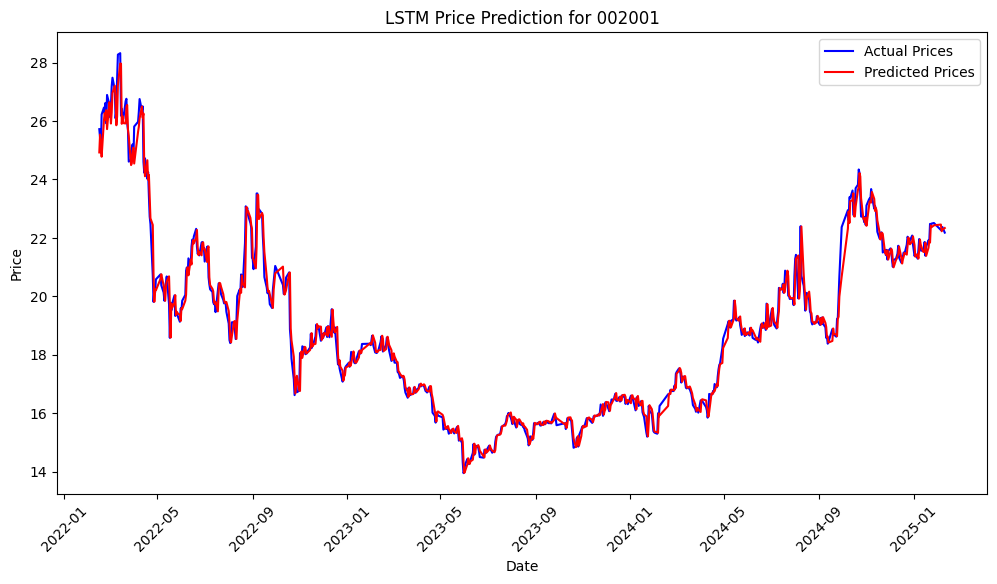

In [322]:

# 可视化
plt.figure(figsize=(12, 6))
plt.plot(price_data.index[-len(y_test_actual):], y_test_actual, label='Actual Prices', color='blue')  # 绘制实际价格
plt.plot(price_data.index[-len(predicted):], predicted, label='Predicted Prices', color='red')  # 绘制预测价格
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.title(f'LSTM Price Prediction for {stock_code}')
plt.show()

In [323]:
# 输出预测结果
print(f"------------------:{stock_code}")
print(f"最后一天的日期: {last_date}, 收盘价格: {last_real_price}, 预测价格: {last_predicted_price}")
for i in range(10):
    print(f"预测日期: {future_dates[i]}, 预测价格: {future_prices[i]}")

------------------:002001
最后一天的日期: 2025-02-10, 收盘价格: 22.18, 预测价格: 22.33722496032715
预测日期: 2025-02-11 00:00:00, 预测价格: 22.15232276916504
预测日期: 2025-02-12 00:00:00, 预测价格: 22.116701126098633
预测日期: 2025-02-13 00:00:00, 预测价格: 22.087779998779297
预测日期: 2025-02-14 00:00:00, 预测价格: 22.05898666381836
预测日期: 2025-02-17 00:00:00, 预测价格: 22.029266357421875
预测日期: 2025-02-18 00:00:00, 预测价格: 21.99878692626953
预测日期: 2025-02-19 00:00:00, 预测价格: 21.968124389648438
预测日期: 2025-02-20 00:00:00, 预测价格: 21.937820434570312
预测日期: 2025-02-21 00:00:00, 预测价格: 21.908241271972656
预测日期: 2025-02-24 00:00:00, 预测价格: 21.87959861755371


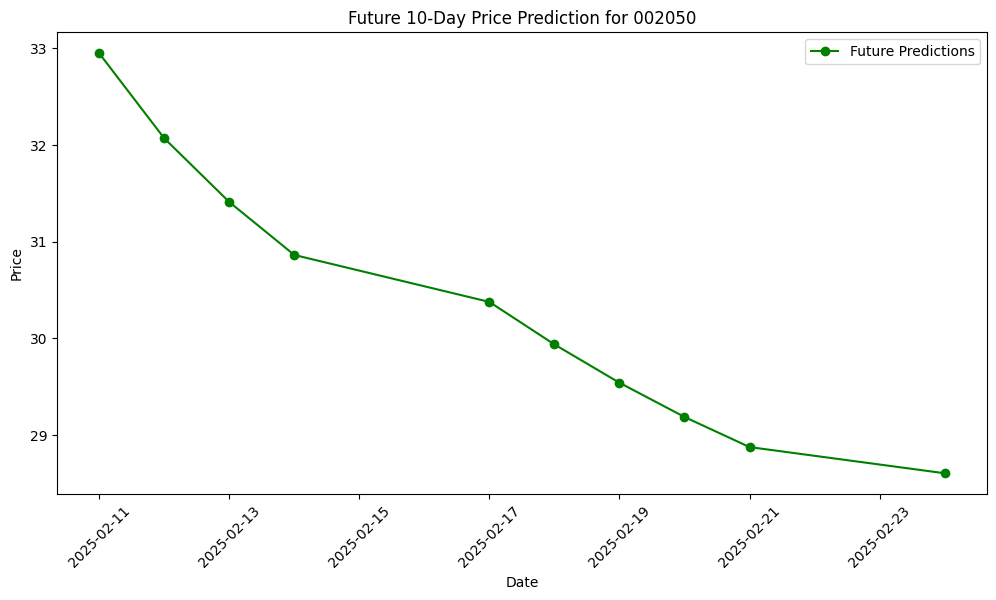

In [311]:
# 绘制未来10天的预测价格走势
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_prices, marker='o', linestyle='-', color='green', label='Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.title(f'Future 10-Day Price Prediction for {stock_code}')
plt.show()